In [1]:
import time
import cv2
import os
import time
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.utils import _pair, _quadruple
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

class CustomDataset(Dataset):
    """Stores data on CPU and lets DataLoader move to device.
    FC: (N, H, W, C_in)
    DTO: (N, H, W, 1)
    com: (N,) scalar compliance targets per sample
    """
    def __init__(self,FC,DTO,com):
        self.x_data = torch.cuda.FloatTensor(FC)
        self.x_data = self.x_data.permute(0,3,1,2) #

        self.y_data = torch.cuda.FloatTensor(DTO)
        self.y_data = self.y_data.permute(0,3,1,2)

        self.z_data = torch.cuda.FloatTensor(com)
        
        self.len = self.y_data.shape[0]
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index], self.z_data[index]

class CNN_top(nn.Module):
    def __init__(self):
        super(CNN_top, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(4,32,2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,32,3,padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.layer2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.layer4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            )
        self.layer6 = nn.Sequential(
            nn.Conv2d(192,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            )
        self.layer7 = nn.Sequential(
            nn.Conv2d(96,32,3,padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,32,3,padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.layer8 =  nn.Sequential(
             nn.Conv2d(32,1,3,padding="same"),
             nn.Sigmoid(),
            )
        self.conv1 = nn.Sequential(
            nn.Conv2d(384,384,1,1,padding=0),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(192,192,1,1,padding=0),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(96,96,1,1,padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            )
        self.avg = nn.AvgPool2d(3,1,1)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        
        x = self.layer4(x3)
        x = torch.cat([x,x3],dim=1) # 256+128 =384
        
        # topblock 1
        fil1 = x
        x = self.conv1(fil1)
        ori1 = x
        x = self.avg (fil1)
        x = self.conv1(x)
        x = torch.add(x,ori1)

        x = self.layer5(x)
        x = torch.cat([x,x2],dim=1) # 128+64=192
        
        # topblock 2
        fil2 = x
        x = self.conv2(fil2)
        ori2 = x
        x = self.avg (fil2)
        x = self.conv2(x)
        x = torch.add(x,ori2)

        x = self.layer6(x)
        x = torch.cat([x,x1],dim=1) # 64+32=96
        x = self.layer7(x)
        x = self.layer8(x)
        eps = 1e-6
        return x * (1 - eps) + eps
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(4,32,2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,32,3,padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.layer2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.layer4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            )
        self.layer6 = nn.Sequential(
            nn.Conv2d(192,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            )
        self.layer7 = nn.Sequential(
            nn.Conv2d(96,32,3,padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,32,3,padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.layer8 =  nn.Sequential(
             nn.Conv2d(32,1,3,padding="same"),
             nn.Sigmoid()
            )

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x = self.layer4(x3)
        x = torch.cat([x,x3],dim=1)
        x = self.layer5(x)
        x = torch.cat([x,x2],dim=1)
        x = self.layer6(x)
        x = torch.cat([x,x1],dim=1)
        x = self.layer7(x)
        x = self.layer8(x)
        eps = 1e-6
        return x * (1 - eps) + eps
    
def comp_cal(DTO, F_X, F_Y,BCM): 
    ## 방향도 고려
    # input: DTO
    nel = DTO.shape
    nelx = nel[1]
    nely = nel[0]

    x = DTO.flatten(order='F')
    F_X=F_X.flatten(order='F')
    F_Y=F_Y.flatten(order='F')

    fx=np.where(F_X!=0)[0]*2
    Bx=F_X[np.where(F_X!=0)]
    fy=np.where(F_Y!=0)[0]*2+1
    By=F_Y[np.where(F_Y!=0)]
    F=np.r_[fx,fy]
    B=np.r_[Bx,By]
    C=len(F)
    
    l=len(np.where(BCM==1)[0])
    BC_c=np.where(BCM==1)
    BC_a=np.zeros(2*l)

    for i in range(l):
        BC_a[2*i]=2*(BC_c[0][i]+1)*(BC_c[1][i]+1)-2
        BC_a[2*i+1]=2*(BC_c[0][i]+1)*(BC_c[1][i]+1)-1

    penal=3.0;
    rmin=1.5;
    ft=0;
    Emax = 1;
    Emin = 1e-9;
    nu = 0.3;

    ndof = 2*(nelx+1)*(nely+1)
    edofMat=np.zeros((nelx*nely,8),dtype=int)
    nodenrs = np.arange((1+nelx)*(1+nely)).reshape((1+nely,1+nelx),order='F')
    edofVec = (2*nodenrs[:-1,:-1]+1).reshape((nelx*nely,1),order='F')
    edofMat = np.tile(edofVec,(1,8))+np.tile([1, 2, 2*nely+3, 2*nely+4, 2*nely+1 ,2*nely+2, -1, 0],(nelx*nely,1))
    iK = np.kron(edofMat,np.ones((8,1))).flatten()
    jK = np.kron(edofMat,np.ones((1,8))).flatten()

    nu=0.3
    A11 = np.array([12,  3, -6, -3,  3, 12,  3,  0, -6,  3, 12, -3, -3,  0, -3, 12]).reshape(4,4,order='F')
    A12 = np.array([-6, -3,  0,  3, -3, -6, -3, -6,  0, -3, -6,  3,  3, -6,  3, -6]).reshape(4,4,order='F')
    B11 = np.array([-4,  3, -2,  9,  3, -4, -9,  4, -2, -9, -4, -3,  9,  4, -3, -4]).reshape(4,4,order='F')
    B12 = np.array([ 2, -3,  4, -9, -3,  2,  9, -2,  4,  9,  2,  3, -9, -2,  3,  2]).reshape(4,4,order='F')
    KE = 1/(1-nu**2)/24*(np.vstack((np.hstack((A11,A12)),np.hstack((A12.T, A11))))
                         +nu*np.vstack((np.hstack((B11,B12)),np.hstack((B12.T, B11)))))

    dofs=np.arange(2*(nelx+1)*(nely+1))
    fixed=BC_a
    free=np.setdiff1d(dofs,fixed)
    # Solution and RHS vectors
    f=np.zeros((ndof,C))
    u=np.zeros((ndof,C))
    # Set load
    for j in range(C):
            f[F[j],j]=B[j]

    sK=((KE.flatten()[np.newaxis]).T*(Emin+(x)**penal*(Emax-Emin))).flatten(order='F')
    K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()

    # Remove constrained dofs from matrix
    K = K[free,:][:,free]

    # Solve system 
    if C==1:
        u[free,0]=spsolve(K,f[free,0])
    else:
        u[free,:]=spsolve(K,f[free,:])

    # Objective and sensitivity
    ce=np.ones(nely*nelx)
    obj=0
    for i in range(C):
                ui=u[:,i]
                ce[:] = (np.dot(ui[edofMat].reshape(nelx*nely,8),KE) * ui[edofMat].reshape(nelx*nely,8)).sum(1)
                obj = obj+( (Emin+x**penal*(Emax-Emin))*ce ).sum()
    return obj

cuda:0 is available


In [2]:
def processing(FCv,DTO,it=10,ch=0.01):
    nel = DTO.shape
    nelx = nel[1]
    nely = nel[0]
    F_X=FCv[:,:,0]
    F_Y=FCv[:,:,1]
    volfrac=FCv[:,:,2].mean()
    BCM=FCv[:,:,3]
    x = DTO.flatten(order='F')
    F_X=F_X.flatten(order='F')
    F_Y=F_Y.flatten(order='F')

    fx=np.where(F_X!=0)[0]*2
    Bx=F_X[np.where(F_X!=0)]
    fy=np.where(F_Y!=0)[0]*2+1
    By=F_Y[np.where(F_Y!=0)]
    F=np.r_[fx,fy]
    B=np.r_[Bx,By]
    C=len(F)
    l=len(np.where(BCM==1)[0])
    BC_c=np.where(BCM==1)
    BC_a=np.zeros(2*l)

    for i in range(l):
        BC_a[2*i]=2*(BC_c[0][i]+1)*(BC_c[1][i]+1)-2
        BC_a[2*i+1]=2*(BC_c[0][i]+1)*(BC_c[1][i]+1)-1
        
    penal=3
    rmin=1.5
    ft=0
    
    print("Minimum compliance problem with OC")
    print("ndes: " + str(nelx) + " x " + str(nely))
    print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
    print("Filter method: " + ["Sensitivity based","Density based"][ft])
    # Max and min stiffness
    Emin=1e-9
    Emax=1.0
    
    # dofs:
    ndof = 2*(nelx+1)*(nely+1)
    # Allocate design variables (as array), initialize and allocate sens.
    x=DTO.flatten(order='F')
    xold=x.copy()
    xPhys=x.copy()
    g=0 # must be initialized to use the NGuyen/Paulino OC approach
    dc=np.zeros((nely,nelx), dtype=float)
    # FE: Build the index vectors for the for coo matrix format.
    nu=0.3
    A11 = np.array([12,  3, -6, -3,  3, 12,  3,  0, -6,  3, 12, -3, -3,  0, -3, 12]).reshape(4,4,order='F')
    A12 = np.array([-6, -3,  0,  3, -3, -6, -3, -6,  0, -3, -6,  3,  3, -6,  3, -6]).reshape(4,4,order='F')
    B11 = np.array([-4,  3, -2,  9,  3, -4, -9,  4, -2, -9, -4, -3,  9,  4, -3, -4]).reshape(4,4,order='F')
    B12 = np.array([ 2, -3,  4, -9, -3,  2,  9, -2,  4,  9,  2,  3, -9, -2,  3,  2]).reshape(4,4,order='F')
    KE = 1/(1-nu**2)/24*(np.vstack((np.hstack((A11,A12)),np.hstack((A12.T, A11))))
                         +nu*np.vstack((np.hstack((B11,B12)),np.hstack((B12.T, B11)))))
    ndof = 2*(nelx+1)*(nely+1)
    edofMat=np.zeros((nelx*nely,8),dtype=int)
    nodenrs = np.arange((1+nelx)*(1+nely)).reshape((1+nely,1+nelx),order='F')
    edofVec = (2*nodenrs[:-1,:-1]+1).reshape((nelx*nely,1),order='F')
    edofMat = np.tile(edofVec,(1,8))+np.tile([1, 2, 2*nely+3, 2*nely+4, 2*nely+1 ,2*nely+2, -1, 0],(nelx*nely,1))
    iK = np.kron(edofMat,np.ones((8,1))).flatten()
    jK = np.kron(edofMat,np.ones((1,8))).flatten()
    # Filter: Build (and assemble) the index+data vectors for the coo matrix format
    nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
    iH = np.zeros(nfilter)
    jH = np.zeros(nfilter)
    sH = np.zeros(nfilter)
    cc=0
    for i in range(nelx):
        for j in range(nely):
            row=i*nely+j
            kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
            kk2=int(np.minimum(i+np.ceil(rmin),nelx))
            ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
            ll2=int(np.minimum(j+np.ceil(rmin),nely))
            for k in range(kk1,kk2):
                for l in range(ll1,ll2):
                    col=k*nely+l
                    fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                    iH[cc]=row
                    jH[cc]=col
                    sH[cc]=np.maximum(0.0,fac)
                    cc=cc+1
    # Finalize assembly and convert to csc format
    H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
    Hs=H.sum(1)
    # BC's and support
    dofs=np.arange(2*(nelx+1)*(nely+1))
    fixed=BC_a
    free=np.setdiff1d(dofs,fixed)
    # Solution and RHS vectors
    f=np.zeros((ndof,C))
    u=np.zeros((ndof,C))
    # Set load
    for j in range(C):
            f[F[j],j]=B[j]

    # Initialize plot and plot the initial design
    plt.ion() # Ensure that redrawing is possible
    fig,ax = plt.subplots()
    im = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
    interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
    # Set loop counter and gradient vectors 
    loop=0
    change=1
    dv = np.ones(nely*nelx)
    dc = np.ones(nely*nelx)
    ce = np.ones(nely*nelx)
    obj=10**4
    
    while change>ch and loop<it :#and (obj-COM)/COM>0.1:
        loop=loop+1
        # Setup and solve FE problem
        sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
        K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
        # Remove constrained dofs from matrix
        K = K[free,:][:,free]
        # Solve system 
        u[free,:]=spsolve(K,f[free,:])   
        # Objective and sensitivity
        obj = 0
        dc[:] = 0
        for i in range(C):
            ui=u[:,i]
            ce[:] = (np.dot(ui[edofMat].reshape(nelx*nely,8),KE) * ui[edofMat].reshape(nelx*nely,8)).sum(1)
            obj = obj+((Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
            dc[:]= dc[:]+(-penal*xPhys**(penal-1)*(Emax-Emin))*ce
        dv[:] = np.ones(nely*nelx)

        dc[:] = np.asarray((H*(x*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,x)

        # Optimality criteria
        xold[:]=x
        (x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)

        # Filter design variables
        xPhys[:]=x
        # Compute the change by the inf. norm
        change=np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)
        # Plot to screen\   
        im.set_array(-xPhys.reshape((nelx,nely)).T)
        fig.canvas.draw()
        # Write iteration history to screen (req. Python 2.6 or newer)
        print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
                   loop,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))
    sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
    K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
    # Remove constrained dofs from matrix
    K = K[free,:][:,free]
    # Solve system 
    u[free,:]=spsolve(K,f[free,:])
    # Objective and sensitivity
    obj = 0

    for i in range(C):
            ui=u[:,i]
            ce[:] = (np.dot(ui[edofMat].reshape(nelx*nely,8),KE) * ui[edofMat].reshape(nelx*nely,8)).sum(1)
            obj = obj+( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
            
    X = xPhys.reshape(nely,nelx,order='F')
    # Make sure the plot stays and that the shell remains
    plt.show()
    
    return (X, obj, loop)

# Optimality criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
    l1=0
    l2=1e9
    move=0.2
    # reshape to perform vector operations
    xnew=np.zeros(nelx*nely)
    while (l2-l1)>1e-3*(l1+l2):
        lmid=0.5*(l2+l1)
        xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
        gt=g+np.sum((dv*(xnew-x)))
        if gt>0 :
            l1=lmid
        else:
            l2=lmid
    return (xnew,gt)

def heavyside_fun(rho, beta=8.0, eta=0.5):
    # rho: float 또는 np.ndarray, [0,1] 범위 권장
    num = np.tanh(beta*eta) + np.tanh(beta*(rho - eta))
    den = np.tanh(beta*eta) + np.tanh(beta*(1.0 - eta))
    return num / den

In [3]:
name_32 = 'model.pt'
# model directory (trained_model example 32x32 cantilever beam)
cnn_32 = torch.load(name_32)
cnn_32.eval()

CNN_top(
  (layer1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (layer3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), s

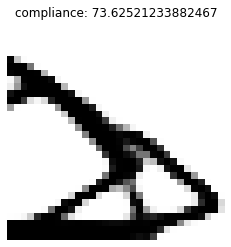

In [4]:
x_data_32=np.zeros((1,4,33,33))

# f_idx : coordinates (x, y) where external forces are applied, values range from 0 to 32
f_idx = np.array([[32,21],[21,19],[10,5],[27,31]])

# f_th : force directions (angles in radians) at each coordinate
f_th = np.array([np.pi/5, np.pi*10/7, 3.5, 1,2])

# volf : target volume fraction for the design
volf = 0.23

for i in range(f_idx.shape[0]):
    x_data_32[0,0][f_idx[i,0],f_idx[i,1]] = np.cos(f_th[i])
    x_data_32[0,1][f_idx[i,0],f_idx[i,1]] = np.sin(f_th[i])
    
x_data_32[0,2] = np.ones((33,33))*volf
x_data_32[0,3,:,0] = 1.0



test_output = cnn_32(torch.tensor(x_data_32).float().to(device))

plt.imshow(1-test_output.view(32,32).cpu().detach().numpy(),cmap='gray')

plt.imshow(1-heavyside_fun(test_output.view(32,32).cpu().detach().numpy()),cmap='gray')
plt.axis('off')
comp_xx = comp_cal(heavyside_fun(test_output.view(32,32).cpu().detach().numpy()),
                   x_data_32[0][0],x_data_32[0][1],x_data_32[0][3])
plt.title(f'compliance: {comp_xx}')
plt.show()

Minimum compliance problem with OC
ndes: 32 x 32
volfrac: 0.23000000000000004, rmin: 1.5, penal: 3
Filter method: Sensitivity based
it.: 1 , obj.: 100.755 Vol.: 0.230, ch.: 0.200
it.: 2 , obj.: 91.013 Vol.: 0.230, ch.: 0.200
it.: 3 , obj.: 87.041 Vol.: 0.230, ch.: 0.134
it.: 4 , obj.: 84.814 Vol.: 0.230, ch.: 0.091
it.: 5 , obj.: 83.285 Vol.: 0.230, ch.: 0.062
it.: 6 , obj.: 82.206 Vol.: 0.230, ch.: 0.047
it.: 7 , obj.: 81.491 Vol.: 0.230, ch.: 0.047
it.: 8 , obj.: 81.049 Vol.: 0.230, ch.: 0.039
it.: 9 , obj.: 80.713 Vol.: 0.230, ch.: 0.035
it.: 10 , obj.: 80.450 Vol.: 0.230, ch.: 0.031


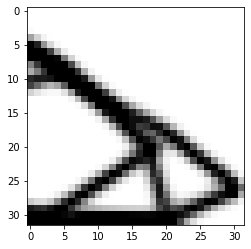

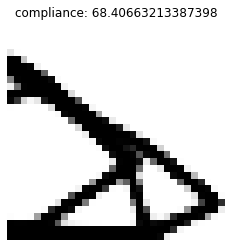

In [5]:
# pre-processing
pro_dto1,_,_ = processing(x_data_32[0].transpose(1,2,0),test_output.view(32,32).cpu().detach().numpy(),10)

plt.imshow(1-heavyside_fun(pro_dto1),cmap='gray')
plt.axis('off')
comp_xx_post = comp_cal(heavyside_fun(pro_dto1),x_data_32[0][0],x_data_32[0][1],x_data_32[0][3])
plt.title(f'compliance: {comp_xx_post}')
plt.show()